In [1]:
#217 page
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
%matplotlib inline

In [2]:
def sin(x, T=100):
    return np.sin(2.0*np.pi*x/T)

In [24]:
def toy_problem(T=100, ampl=0.05):
    x = np.arange(0,2*T+1)
    noise = ampl*np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x)+noise

In [4]:
T = 100
f = toy_preoblem(T)

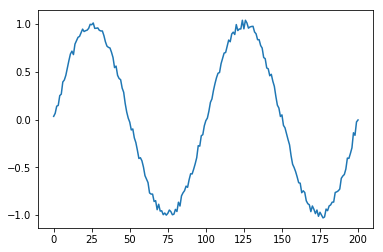

In [5]:
plt.plot(f)

In [6]:
length_of_sequences = 2*T
maxlen = 25

data = []
target = []

#predict the value in t+1 by t-24 ~  t during 2T period
for i in range(0,length_of_sequences-maxlen+1):
    data.append(f[i:i+maxlen])
    target.append(f[i+maxlen])

In [7]:
X = np.array(data).reshape(len(data),maxlen,1)
Y = np.array(target).reshape(len(data),1)

In [8]:
N_train = int(len(data)*0.9)
N_validation = len(data)-N_train

X_train, X_validation, Y_train, Y_validation =train_test_split(X, Y, test_size = N_validation)

# TensorFlow

In [9]:
import tensorflow as tf

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
def inference(x, n_batch, maxlen=None, n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)
    
    cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
    initial_state = cell.zero_state(n_batch, tf.float32)
    
    state = initial_state
    outputs = []
    with tf.variable_scope('RNN'):
        for t in range(maxlen):
            if t> 0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)
    
    output = outputs[-1]
    
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c
    
    return y

def loss(y,t):
    mse = tf.reduce_mean(tf.square(y - t))
    return mse

def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2= 0.999)
    train_step = optimizer.minimize(loss)
    return train_step


class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [11]:
tf.reset_default_graph()
n_in = len(X[0][0])
n_hidden = 30
n_out =len(Y[0])
n_batch= 10
early_stopping = EarlyStopping(patience=10, verbose=1)
history = {'val_loss': []}


x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, shape=[])

y = inference(x, n_batch, maxlen, n_hidden, n_out)
loss = loss(y, t)
train_step = training(loss)

epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

n_batches = N_train // batch_size

for epoch in range(epochs):
    X_,Y_ = shuffle(X_train,Y_train)
    
    for i in range(n_batches):
        start = i*batch_size
        end = start+batch_size
        
        sess.run(train_step, feed_dict={
            x: X_[start:end],
            t: Y_[start:end],
            n_batch: batch_size
        })
        
    # 検証データ, を用いた評価
    val_loss = loss.eval(session=sess, feed_dict={
            x: X_validation,
            t: Y_validation,
            n_batch: N_validation
        })
    
    history["val_loss"].append(val_loss)
    print('epoch:',epoch,"validation_loss:",val_loss)
    
    #Early stopping
    if early_stopping.validate(val_loss):
        break

epoch: 0 validation_loss: 0.21494037
epoch: 1 validation_loss: 0.061807096
epoch: 2 validation_loss: 0.06658472
epoch: 3 validation_loss: 0.06425537
epoch: 4 validation_loss: 0.03415197
epoch: 5 validation_loss: 0.023947915
epoch: 6 validation_loss: 0.012951753
epoch: 7 validation_loss: 0.009893458
epoch: 8 validation_loss: 0.007520911
epoch: 9 validation_loss: 0.004923736
epoch: 10 validation_loss: 0.004322268
epoch: 11 validation_loss: 0.0034164595
epoch: 12 validation_loss: 0.0016201043
epoch: 13 validation_loss: 0.003484189
epoch: 14 validation_loss: 0.0029185573
epoch: 15 validation_loss: 0.0022609348
epoch: 16 validation_loss: 0.0024872916
epoch: 17 validation_loss: 0.0025990813
epoch: 18 validation_loss: 0.0015309097
epoch: 19 validation_loss: 0.0021411176
epoch: 20 validation_loss: 0.0026223967
epoch: 21 validation_loss: 0.0022356776
epoch: 22 validation_loss: 0.003002458
epoch: 23 validation_loss: 0.0022069828
epoch: 24 validation_loss: 0.002911799
epoch: 25 validation_loss: 0

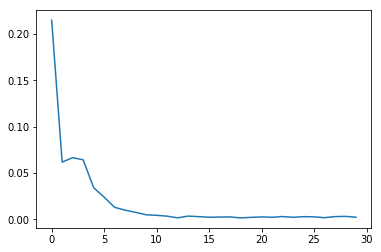

In [21]:
plt.figure()
plt.plot(history['val_loss'])

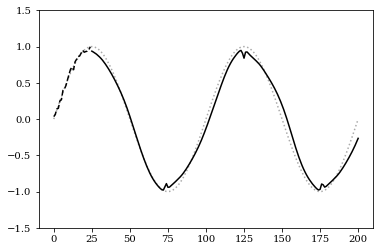

In [25]:
 '''
    出力を用いて予測
'''
truncate = maxlen
Z = X[:1]  # 元データの最初の一部だけ切り出し

original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences - maxlen + 1):
    # 最後の時系列データから未来を予測
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict={
        x: Z[-1:],
        n_batch: 1
    })
    # 予測結果を用いて新しい時系列データを生成
    sequence_ = np.concatenate((z_.reshape(maxlen, n_in)[1:], y_), axis=0).reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

    '''
    グラフで可視化
    '''
plt.rc('font', family='serif')
plt.figure()
plt.ylim([-1.5, 1.5])
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

# Keras

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import SimpleRNN
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [32]:
def weight_variable(shape, name=None):
    return np.random.normal(scale=.01, size=shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


model = Sequential()
model.add(SimpleRNN(n_hidden,
                    kernel_initializer=weight_variable,
                    input_shape=(maxlen, n_in)))
model.add(Dense(n_out, kernel_initializer=weight_variable))
model.add(Activation('linear'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error',
              optimizer=optimizer)

In [33]:
epochs = 500
batch_size = 10

model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_validation, Y_validation),
          callbacks=[early_stopping])

Train on 158 samples, validate on 18 samples
Epoch 1/500
158/158 [==============================] - 1s 3ms/step - loss: 0.4755 - val_loss: 0.3561
Epoch 2/500
158/158 [==============================] - 0s 423us/step - loss: 0.3496 - val_loss: 0.1769
Epoch 3/500
158/158 [==============================] - 0s 436us/step - loss: 0.1362 - val_loss: 0.0587
Epoch 4/500
158/158 [==============================] - 0s 467us/step - loss: 0.0560 - val_loss: 0.0488
Epoch 5/500
158/158 [==============================] - 0s 398us/step - loss: 0.0417 - val_loss: 0.0439
Epoch 6/500
158/158 [==============================] - 0s 473us/step - loss: 0.0319 - val_loss: 0.0279
Epoch 7/500
158/158 [==============================] - 0s 486us/step - loss: 0.0292 - val_loss: 0.0188
Epoch 8/500
158/158 [==============================] - 0s 404us/step - loss: 0.0228 - val_loss: 0.0162
Epoch 9/500
158/158 [==============================] - 0s 410us/step - loss: 0.0158 - val_loss: 0.0077
Epoch 10/500
158/158 [========

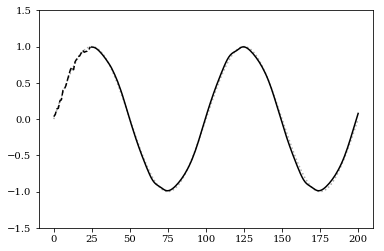

In [34]:
'''
出力を用いて予測
'''
truncate = maxlen
Z = X[:1]  # 元データの最初の一部だけ切り出し

original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences - maxlen + 1):
    z_ = Z[-1:]
    y_ = model.predict(z_)
    sequence_ = np.concatenate(
        (z_.reshape(maxlen, n_in)[1:], y_),
        axis=0).reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

'''
グラフで可視化
'''
plt.rc('font', family='serif')
plt.figure()
plt.ylim([-1.5, 1.5])
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()